In [1]:
import pybinding as pb

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.keys()
plt.rcParams.update({'figure.figsize':(20,10),
                     'font.size':20})

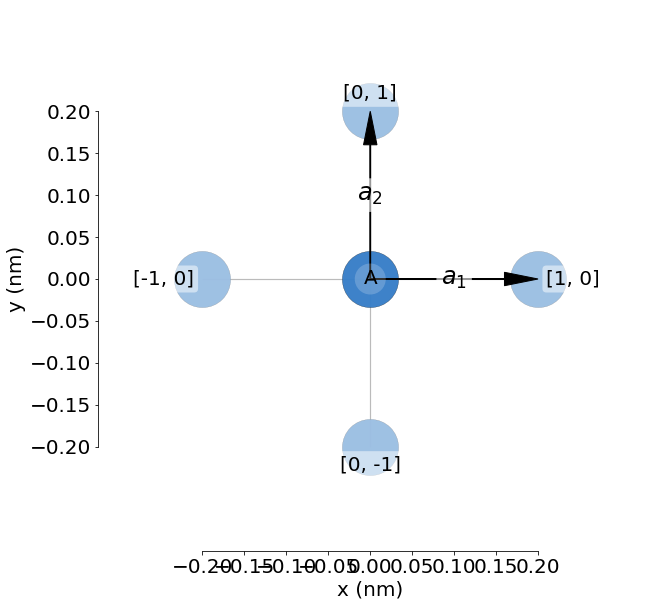

In [2]:
d = 0.2  # [nm] unit cell length
t = 1    # [eV] hopping energy

def square_lattice(d, t):
    lat = pb.Lattice(a1=[d, 0], a2=[0, d])
    lat.add_sublattices(('A', [0, 0]))
    lat.add_hoppings(([0, 1], 'A', 'A', t),
                     ([1, 0], 'A', 'A', t))
    return lat


# we can quickly set a shorter unit length `d`
lattice = square_lattice(d=0.2, t=1)


plt.figure(figsize=(20,10))
lattice.plot()

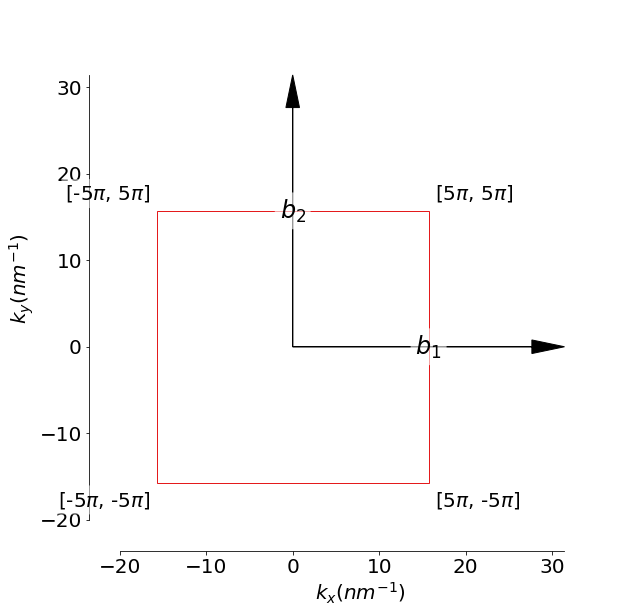

In [3]:
plt.figure(figsize=(20,10))
lattice.plot_brillouin_zone()

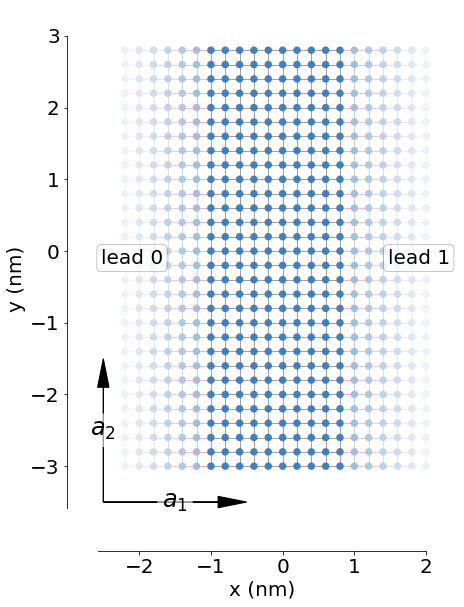

In [4]:
# make model
model = pb.Model(
    # use the lattice we made
    lattice,
    # define number of repetition
    pb.primitive(a1=10, a2=30)
)

# attach leads
model.attach_lead(direction=-1, contact=pb.line([1, 1000], 
                                                [1, -1000]))
model.attach_lead(direction=1, contact=pb.line([1, 1000], 
                                               [1, -1000]))



plt.figure(figsize=(20,10))
model.lattice.plot_vectors(position=[-2.5,-3.5], scale=10)
model.plot()

#print(model.system.x, model.system.y)
#print(model.system.sublattices, model.hamiltonian)
#print(model.hamiltonian.todense())

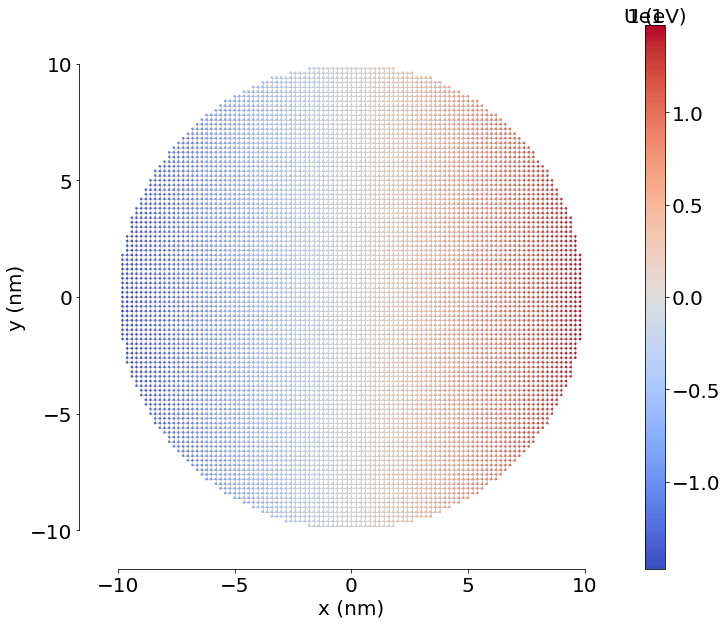

In [5]:
def circle(radius):
    def contains(x, y, z):
        return np.sqrt(x**2 + y**2) < radius
    return pb.FreeformShape(contains, width=[2*radius, 2*radius])


def linear(k):
    @pb.onsite_energy_modifier
    def potential(energy, x):
        return energy + k*x
    return potential



circle_model = pb.Model(
    lattice,
    circle(radius=10),
    linear(1.5)
)
circle_model.onsite_map.plot(cmap="coolwarm", site_radius=0.04) # plot_contourf()
pb.pltutils.colorbar(label="U (eV)")

In [6]:
solver = pb.solver.arpack(model, k=50)
circle_solver = pb.solver.arpack(circle_model, k=50)

#print(solver.eigenvalues)
#print(solver.eigenvectors)

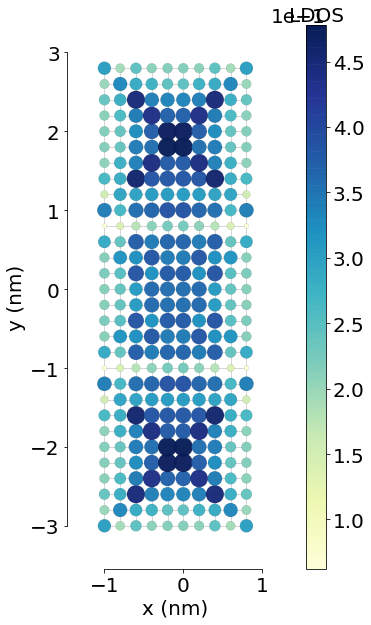

In [7]:
ldos = solver.calc_spatial_ldos(energy=0, broadening=0.05)  # eV
ldos.plot(site_radius=(0.03, 0.12))
pb.pltutils.colorbar(label="LDOS")

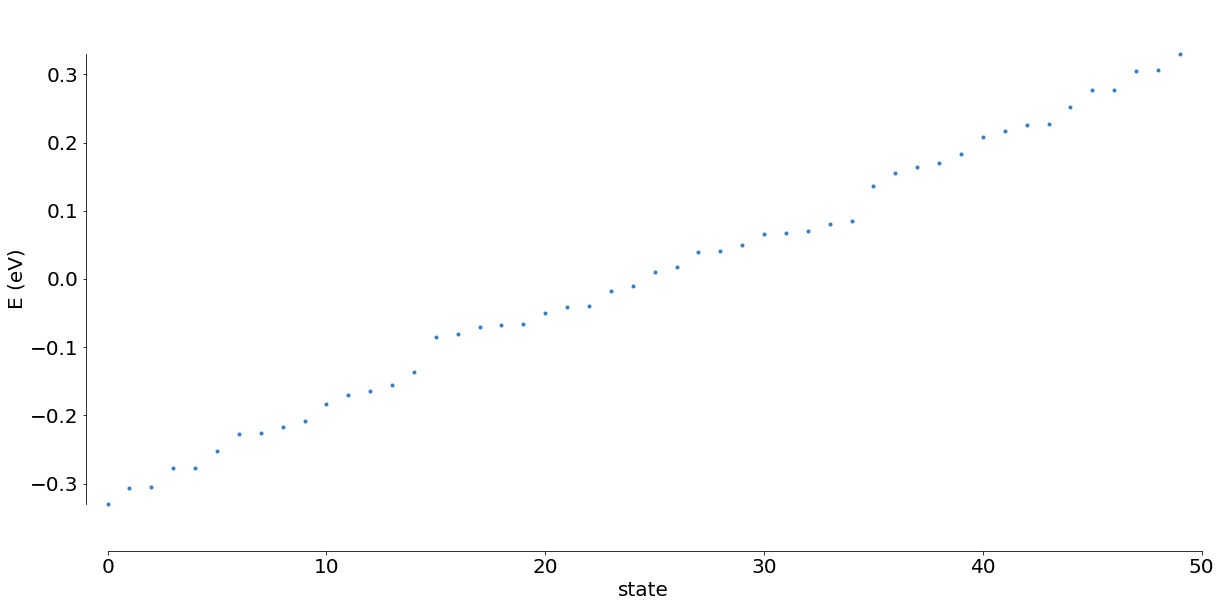

In [8]:
eigenvalues = solver.calc_eigenvalues()
eigenvalues.plot()
plt.show()

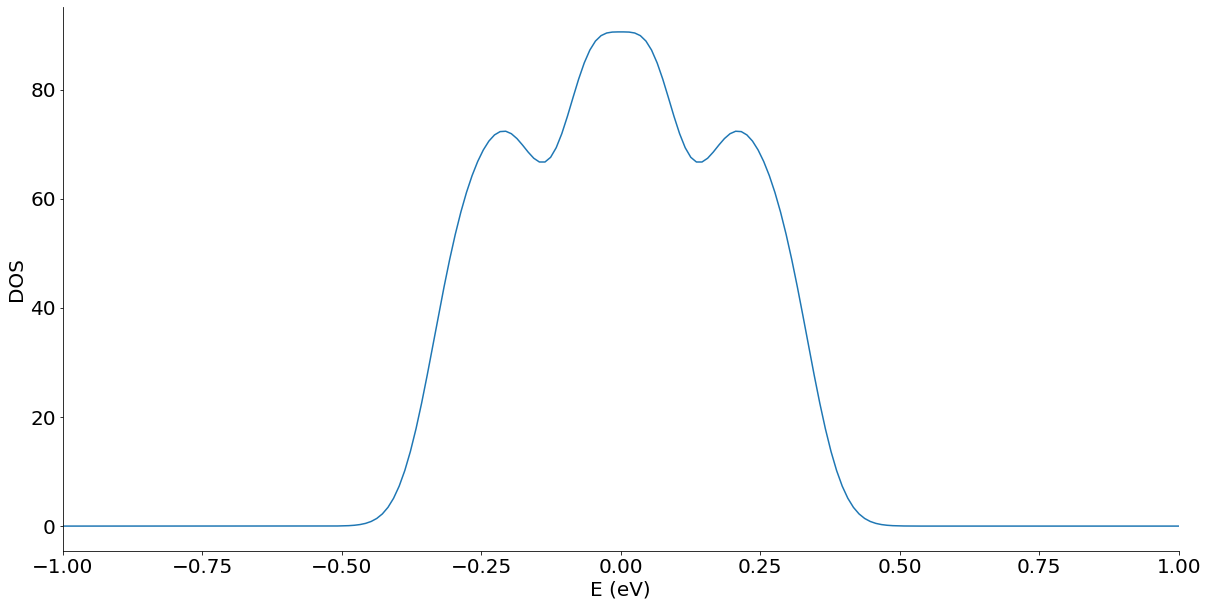

In [9]:
dos = solver.calc_dos(energies=np.linspace(-1, 1, 200), broadening=0.05)  # [eV]
dos.plot()

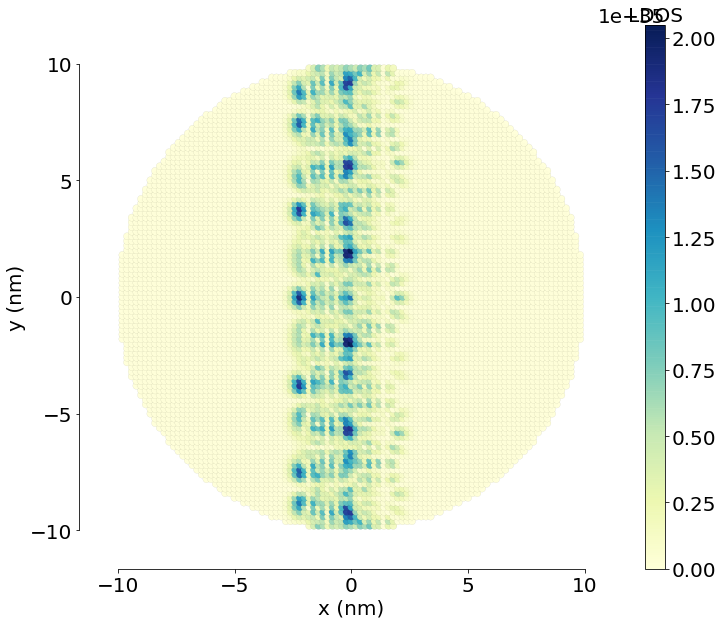

In [10]:
circle_ldos = circle_solver.calc_spatial_ldos(energy=0.7, broadening=0.05)  # eV
circle_ldos.plot(site_radius=(0.03, 0.12))
pb.pltutils.colorbar(label="LDOS")

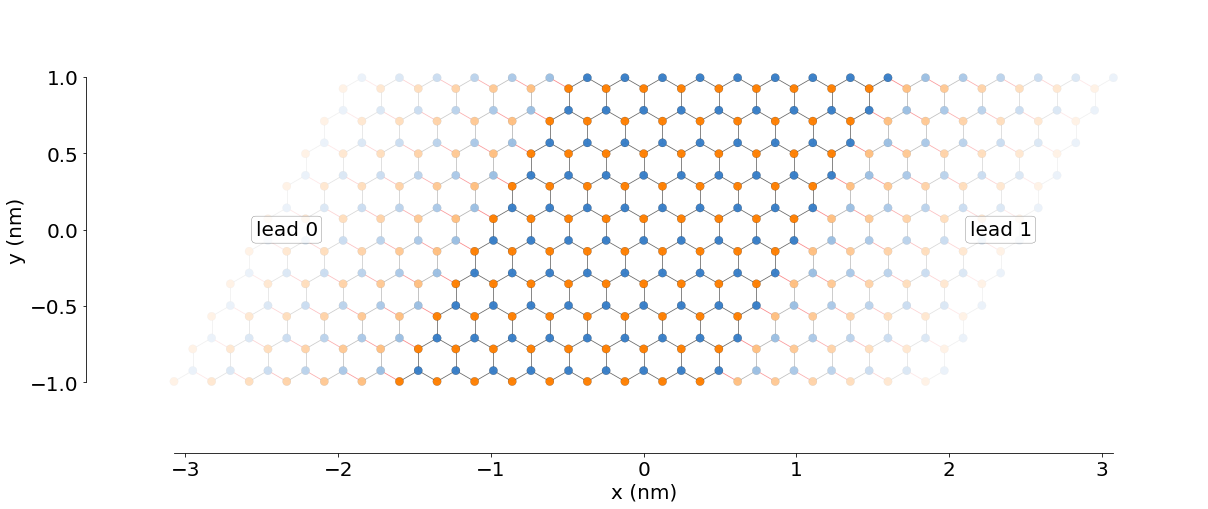

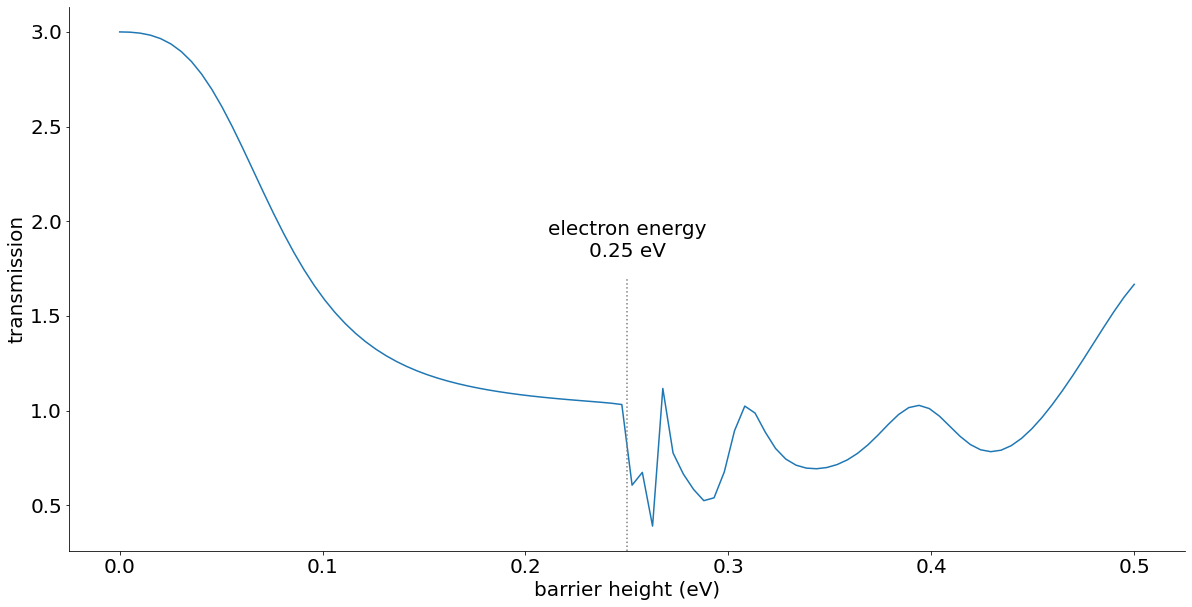

In [11]:
import kwant
import pybinding as pb
from pybinding.repository import graphene

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.keys()
plt.rcParams.update({'figure.figsize':(20,10),
                     'font.size':20})


def potential_barrier(v0, x0):
    """Barrier height `v0` in eV with spatial position `-x0 <= x <= x0`"""
    @pb.onsite_energy_modifier(is_double=True)  # enable double-precision floating-point
    def function(energy, x):
        energy[np.logical_and(-x0 <= x, x <= x0)] = v0
        return energy
    return function

def make_model(length, width, v0=0):
    model = pb.Model(
        graphene.monolayer(),
        pb.rectangle(length, width),
        potential_barrier(v0, length / 4)
    )
    model.attach_lead(-1, pb.line([-length/2, -width/2], [-length/2, width/2]))
    model.attach_lead(+1, pb.line([ length/2, -width/2], [ length/2, width/2]))
    return model

model = make_model(length=1, width=2)  # nm
model.plot()





length, width = 15, 15  # nm
electron_energy = 0.25  # eV
barrier_heights = np.linspace(0, 0.5, 100)  # eV

transmission = []
for v in barrier_heights:
    model = make_model(length, width, v)  # pybinding model
    kwant_system = model.tokwant()  # export to kwant
    smatrix = kwant.smatrix(kwant_system, energy=electron_energy)
    transmission.append(smatrix.transmission(1, 0))
    
    
    
plt.figure(figsize=(20,10))  
plt.plot(barrier_heights, transmission)
plt.ylabel("transmission")
plt.xlabel("barrier height (eV)")
plt.axvline(electron_energy, 0, 0.5, color="gray", linestyle=":")
plt.annotate("electron energy\n{} eV".format(electron_energy), (electron_energy, 0.54),
             xycoords=("data", "axes fraction"), horizontalalignment="center")
pb.pltutils.despine()  # remove top and right axis lines

For each system size, the transmission is calculated as a function of barrier height for 100 values. Even though pybinding reconstructs the entire model every time the barrier is changed, the system build time is so fast that it doesn’t affect the total calculation time. In fact, the extremely fast build actually enables pybinding to outperform Kwant in the overall calculation. Even though Kwant only repopulates field data at each loop iteration, this still takes more time than it does for pybinding to fully reconstruct the system.

Note that this example presents a relatively simple system with a square barrier. This is done to keep the run time to only a few minutes, for convenience. Here, pybinding speeds up the overall calculation by about 40%. For more realistic examples with larger scattering regions and complicated field functions with multiple parameters, a speedup of 3-4 times can be achieved by using pybinding’s model builder.